## Ex-04

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

### Task 1

#### 1.1

In [168]:
def simulate_sir_simple(lam, mu, I0, T, N):
    X = [] # observations
    C = [] # states

    I = I0 # number of infected individuals
    R = 0 # number of recovered individuals
    S = N - I - R # number of susceptible individuals

    for t in range(T):
        C.append((S, I, R))

        dS = -lam * S * I / N
        dI = lam * S * I / N - (mu * I)
        dR = mu * I

        # for T+1
        S_next = S + dS
        I_next = I + dI
        R_next = R + dR

        dS = S - S_next
        dR = R_next - R

        X.append((dS, dR))

        S,I,R = S_next, I_next, R_next
    
    return np.array(X), np.array(C)

#### 1.2

In [169]:
def explore_prior(N, T, lam_list, mu_list, I0_list):
    fig, axes = plt.subplots(len(lam_list), len(mu_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, lam in enumerate(lam_list):
        for j, mu in enumerate(mu_list):
            for I0 in I0_list:
                _, states = simulate_sir_simple(lam, mu, I0, T, N)
                
                S,I,R = zip(*states)
                S, I, R = np.array(S), np.array(I), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), I0={I0}')
                ax.plot(range(T), I, label=f'I(t), I0={I0}')
                ax.plot(range(T), R, label=f'R(t), I0={I0}')
                ax.set_title(f'λ={lam}, μ={mu}')
                ax.set_xlabel('days')
                ax.set_ylabel('population')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(I0_list))
    plt.tight_layout()
    plt.show()

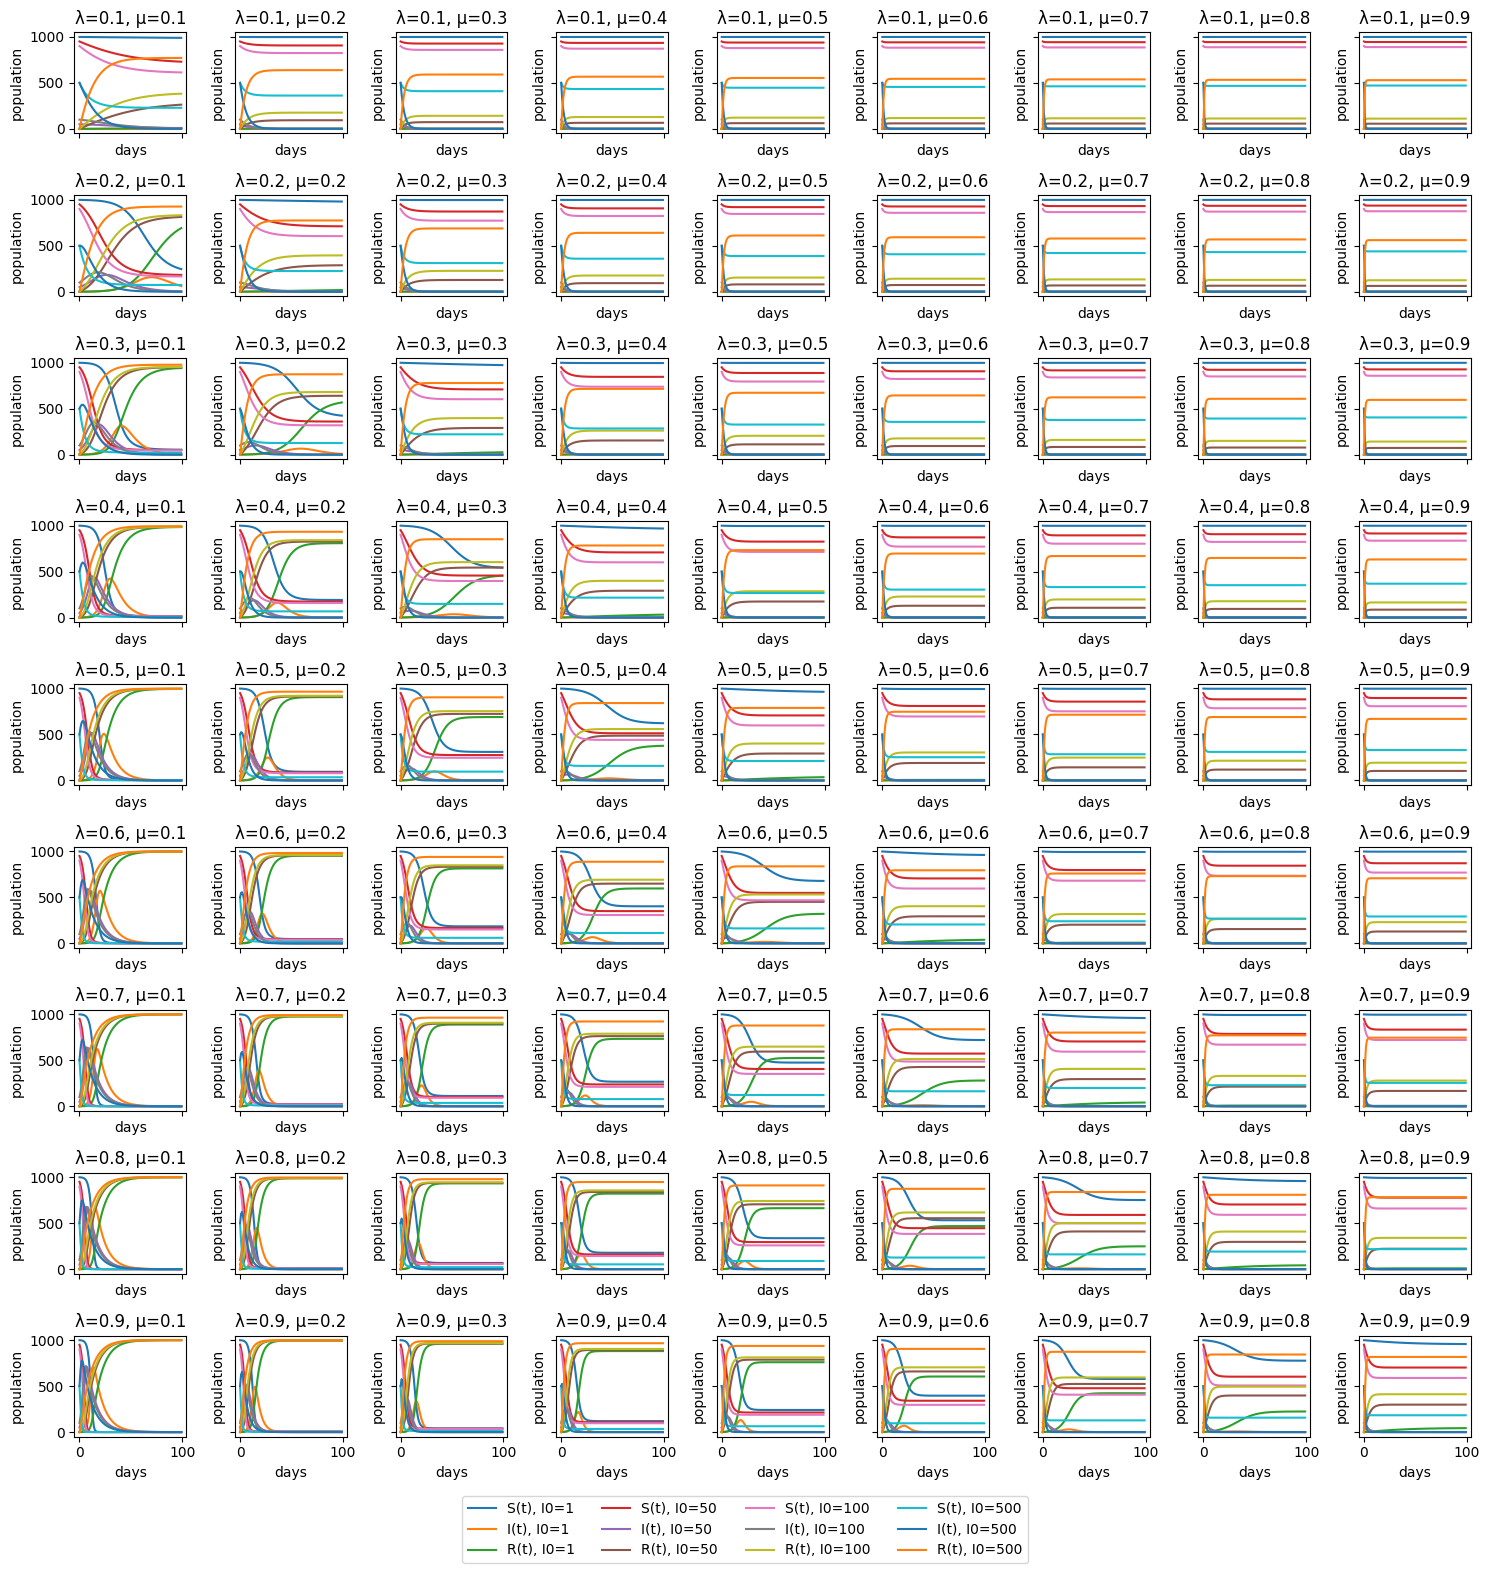

In [170]:
N = 1000
T = 100

# hyperparameters
lam_list = np.round(np.linspace(0.1, 0.9, 9),1)
mu_list = np.round(np.linspace(0.1, 0.9, 9),1)
I0_list =  [1, 50, 100, 500]

explore_prior(N, T, lam_list, mu_list, I0_list)



With range
* lambda = [0.2, 0.9]
* mu = [0.1, 0.7]
* I_0 = [1, 100]
  
the most diverse dynamics are observed.

#### 1.3

In [171]:
def generate_sir_data(num_samples, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1,100)

        X, _ = simulate_sir_simple(lam, mu, I0, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0])

    return np.array(data), np.array(target)

class SIRDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]
    
class SIRModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SIRModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [172]:
def train_model(model, criterion, optimizer, data_loader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            
            output = model(x_batch)
            
            loss = criterion(output, y_batch)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(data_loader))
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    return losses

def test_model(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)

Training mode ...
Epoch 1/50, Loss: 271.1075
Epoch 6/50, Loss: 11.2025
Epoch 11/50, Loss: 1.4276
Epoch 16/50, Loss: 0.5401
Epoch 21/50, Loss: 0.3873
Epoch 26/50, Loss: 0.3125
Epoch 31/50, Loss: 0.2590
Epoch 36/50, Loss: 0.1936
Epoch 41/50, Loss: 0.2905
Epoch 46/50, Loss: 0.1922


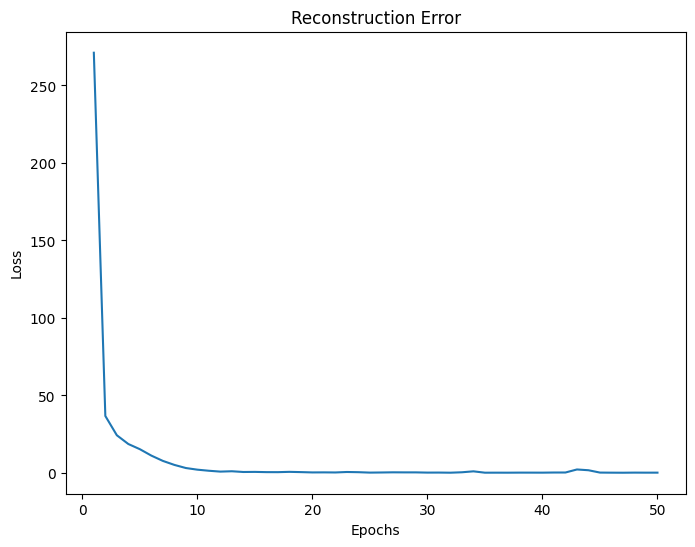

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


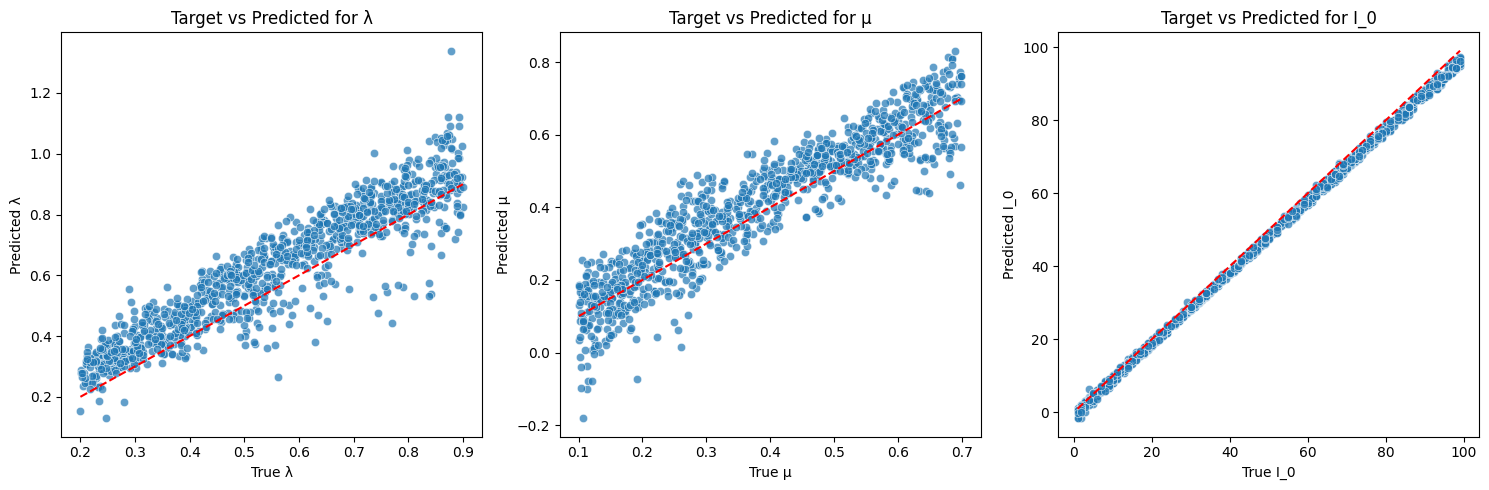

In [173]:
# hyperparameters
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 3 # [lam, mu, I0]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


#### 1.4

In [174]:
# Conditional realNVP components
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.split1 = input_size // 2
        self.split2 = input_size - self.split1

        self.subnet = nn.Sequential(
            nn.Linear(self.split1 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * self.split2),
        )

    def forward(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        log_jacob_det = torch.sum(s, dim=-1)

        x2 = torch.exp(s) * x2 + t
        return torch.cat([x1, x2], dim=-1), log_jacob_det


    def reverse(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        x2 = (x2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=-1)

class ConditionalrealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, n_layers):
        super(ConditionalrealNVP, self).__init__()
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(n_layers)
        ])

    def forward(self, x, context):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x, context)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z, context):
        for layer in reversed(self.layers):
            z = layer.reverse(z, context)
        return z

In [175]:
def train_realNVP(feature_extractor, realNVP, optimizer, data_loader, epochs):
    feature_extractor.train()
    realNVP.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()

            context = feature_extractor(x_batch)
            z, log_det_jacobian = realNVP(y_batch, context)
            
            nll = 0.5 * torch.sum(z**2, dim=1) - log_det_jacobian
            loss = torch.mean(nll)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss/len(data_loader))

        if epoch % 2 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    
    return np.array(losses)

def test_realNVP(feature_extractor, realNVP, data_loader):
    feature_extractor.eval()
    realNVP.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            context = feature_extractor(x_batch)
            outputs = realNVP.reverse(torch.randn_like(y_batch), context)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)


Training mode ...
Epoch 1/50, Loss: 68.0469
Epoch 3/50, Loss: 1.4415
Epoch 5/50, Loss: 0.9623
Epoch 7/50, Loss: 0.6465
Epoch 9/50, Loss: 0.4291
Epoch 11/50, Loss: 0.3026
Epoch 13/50, Loss: 0.2387
Epoch 15/50, Loss: 0.1787
Epoch 17/50, Loss: 0.1153
Epoch 19/50, Loss: 0.1909
Epoch 21/50, Loss: 0.0386
Epoch 23/50, Loss: -0.1552
Epoch 25/50, Loss: 0.1002
Epoch 27/50, Loss: 0.0567
Epoch 29/50, Loss: -0.1081
Epoch 31/50, Loss: -0.2176
Epoch 33/50, Loss: -0.4231
Epoch 35/50, Loss: -0.2836
Epoch 37/50, Loss: -0.1140
Epoch 39/50, Loss: -0.7113
Epoch 41/50, Loss: -0.4884
Epoch 43/50, Loss: -0.8670
Epoch 45/50, Loss: -0.9360
Epoch 47/50, Loss: -0.8826
Epoch 49/50, Loss: 0.2584


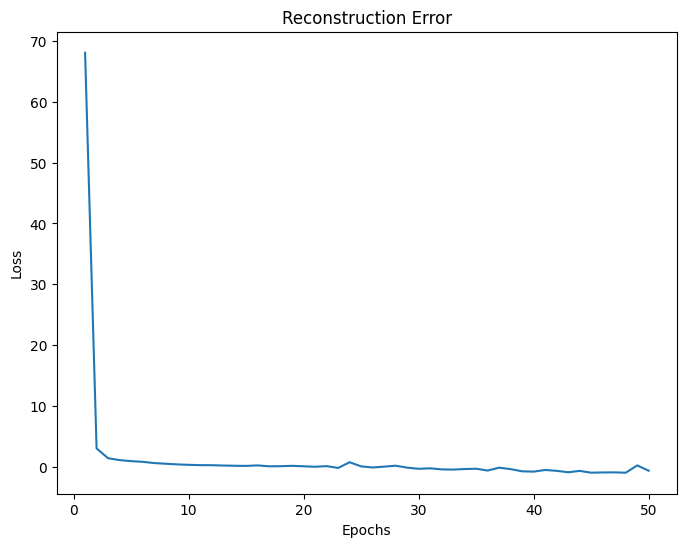

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


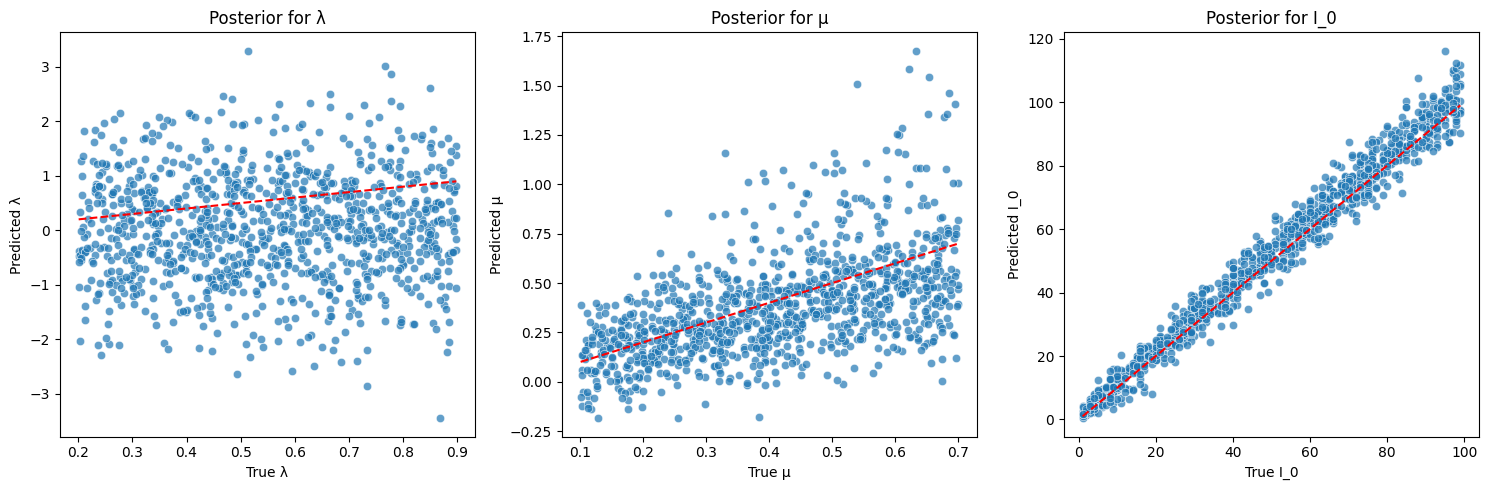

In [176]:
# Hyperparameters
T = 100
N = 1000
num_samples = 5000
test_samples = 1000
input_size = T*2 # Flattened (dS, dR)
hidden_size = 64
batch_size = 64
lr = 0.001
epochs = 50
n_layers=2


# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=3, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


#### 1.5

In [177]:
def generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size):

    feature_extractor.eval()
    realNVP.eval()

    all_samples = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(next(feature_extractor.parameters()).device)
            context = feature_extractor(x)

            samples = []
            for _ in range(num_preds):
                z = torch.randn((x.size(0), input_size), device=context.device)  # Sampling from prior
                sample = realNVP.reverse(z, context)
                samples.append(sample.cpu().numpy())

            all_samples.append(np.stack(samples, axis=0))
            all_targets.append(y.numpy())

    preds = np.concatenate(all_samples, axis=1)  # Shape: (M, len(test_data), num_params)
    targets = np.concatenate(all_targets, axis=0)  # Shape: (len(test_data), num_params)

    return preds, targets

def compute_energy(y_samples, targets):
    
    targets = targets[None, :, :]  # Broadcast for M samples
    energy = -0.5 * np.sum((y_samples - targets) ** 2, axis=-1)  # Gaussian assumption
    return energy

def plot_posterior_distributions(samples, params):

    fig, axes = plt.subplots(2, len(params), figsize=(15, 5))
    for i, param in enumerate(params):
        param_samples = samples[:, :, i].flatten()

        axes[0,i].hist(param_samples, bins=30, density=True, alpha=0.5, label='Posterior Samples')
        axes[0,i].set_title(f'Posterior Histogram - {param}')
        axes[0,i].set_xlabel('Value')
        axes[0,i].set_ylabel('Density')
        axes[0,i].legend()

        # Empirical CDF
        ecdf = np.sort(param_samples)
        axes[1,i].plot(ecdf, np.linspace(0, 1, len(ecdf)), label='Empirical CDF', lw=2)
        axes[1,i].set_title(f'Empirical CDF - {param}')
        axes[1,i].set_xlabel('Value')
        axes[1,i].set_ylabel('Cumulative Probability')
        axes[1,i].legend()

    plt.tight_layout()
    plt.show()

def plot_joint_distribution(samples, params):

    joint_samples = samples.reshape(-1, samples.shape[-1])  # Shape: (M * len(X), num_params)
    df = pd.DataFrame(joint_samples, columns=params)

    sns.pairplot(df, diag_kind='kde', plot_kws={'s': 1, 'alpha':0.5}, corner=True)
    plt.suptitle('Joint Posterior Distribution', y=1)
    plt.show()

Mean Energy Score: -12.3719
Standard Deviation of Energy Scores: 19.1138


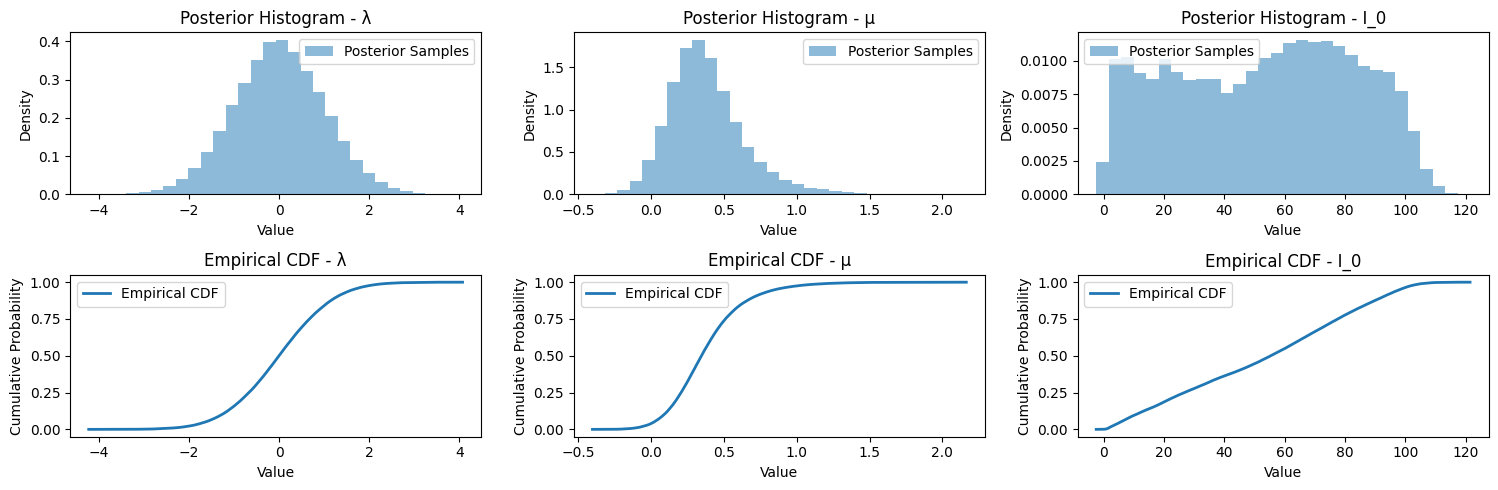

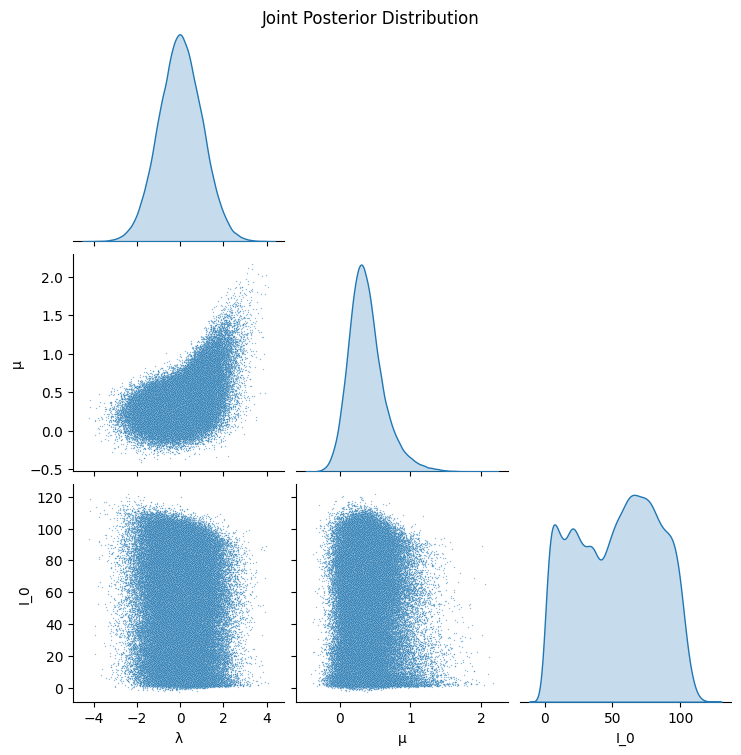

In [178]:
num_preds = 100
input_size = 3
params = ['λ', 'μ', 'I_0']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)


### 1.6

In [179]:
def plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage):

    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)
    
    params = ['dS', 'dR']

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    for i, param in enumerate(params):
        axes[i].fill_between(range(len(lower_bound)), lower_bound[:, i], upper_bound[:, i], color='skyblue', alpha=0.5, label='95% CI')
        axes[i].plot(true_simulated_outcomes[:, i], 'o', color='orange', label='True Outcomes')
        axes[i].set_xlabel('samples')
        axes[i].set_ylabel(f'{param}')
        axes[i].legend()
    plt.suptitle(f'Posterior Predictive Calibration with coverage = {coverage}')
    plt.tight_layout()
    plt.show()

In [180]:
def posterior_predictive_calibration(posterior_samples, simulate_sir_simple, true_outcomes, T, N):

    M = posterior_samples.shape[0]

    resimulated_outcomes = []

    # simulate outcomes for predicted samples
    for k in range(M):
        current_outcomes = []
        for lam, mu, I0 in posterior_samples[k]:
            X, _ = simulate_sir_simple(lam, mu, I0, T, N)
            current_outcomes.append(np.sum(X, axis=0))
        resimulated_outcomes.append(np.stack(current_outcomes, axis=0))

    resimulated_outcomes = np.stack(resimulated_outcomes, axis=0)

    # simulate outcomes for true samples
    true_simulated_outcomes = []
    for lam, mu, I0 in true_outcomes:
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        true_simulated_outcomes.append(np.sum(X, axis=0))

    true_simulated_outcomes = np.stack(true_simulated_outcomes, axis=0)

    # confidence intervals from predicted simulations
    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)

    # Check if true simulated outcomes are within confidence intervals
    true_within_interval = np.logical_and(true_simulated_outcomes >= lower_bound, true_simulated_outcomes <= upper_bound)

    # coverage as the proportion of observations within intervals
    coverage = np.mean(np.all(true_within_interval, axis=1))

    plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage)
    
    
    return coverage


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/1062177979.py:12: RuntimeWarning: overflow encountered in scalar multiply
  dS = -lam * S * I / N
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/1062177979.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dI = lam * S * I / N - (mu * I)
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/1062177979.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  dS = S - S_next
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/1062177979.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dR = R_next - R
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/1062177979.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dI = lam * S * I / N - (mu * I)


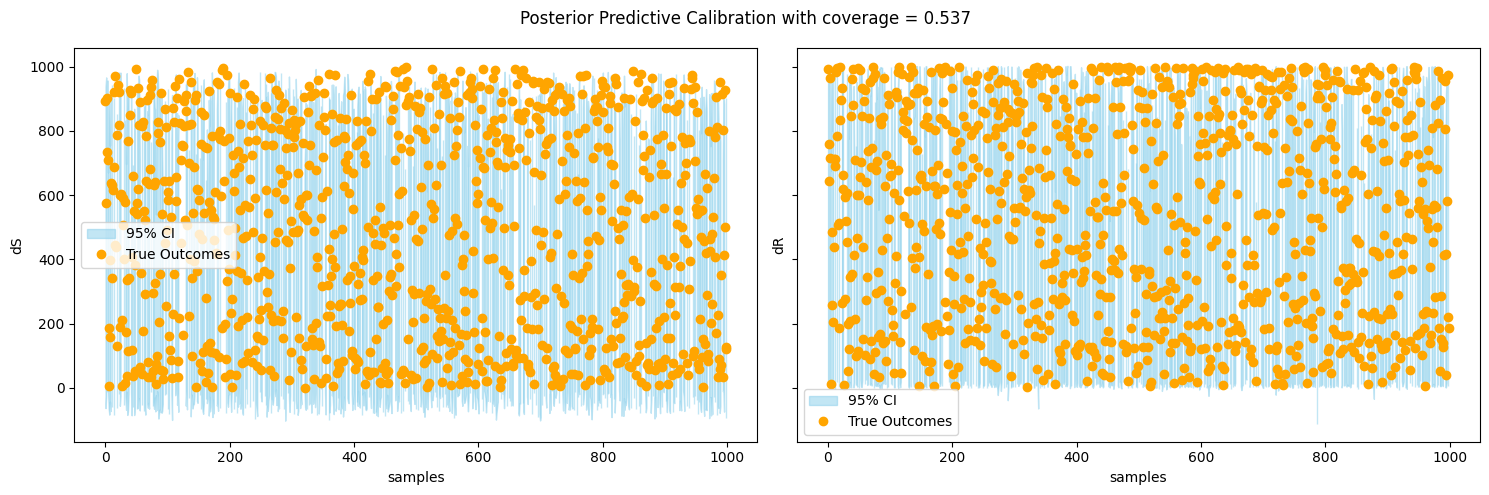

np.float64(0.537)

In [181]:
posterior_predictive_calibration(preds, simulate_sir_simple, y_test, T, N)


### Task 2

#### 2.1

In [182]:
import numpy as np

def simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N):

    X, C = simulate_sir_simple(lam, mu, I0, T, N)

    # multiplicative Gaussian noise
    ep_S = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_I = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_R = np.random.normal(rho, np.sqrt(sigma2), T)

    dS, dR = X[:, 0]*ep_S, X[:, 1]*ep_R
    S, I, R = C[:,0]*ep_S, C[:,1]*ep_I, C[:,2]*ep_R

    X = np.stack([dS, dR], axis=1)
    C = np.stack([S, I, R], axis=1)

    X_shifted = np.roll(X, int(L), axis=0)
    C_shifted = np.roll(C, int(L), axis=0)

    return X_shifted, C_shifted


In [183]:
def explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list):
    fig, axes = plt.subplots(len(rho_list), len(sigma_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, rho in enumerate(rho_list):
        for j, sigma2 in enumerate(sigma_list):
            for L in L_list:
                sim, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)
                
                S, R = zip(*sim)
                S, R = np.array(S), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), L={L}', linewidth=0.5)
                ax.plot(range(T), R, label=f'R(t), L={L}', linewidth=0.5)
                ax.set_title(f'ρ={rho}, σ2={sigma2}')
                ax.set_xlabel('days')
                ax.set_ylabel('value')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(L_list))
    plt.tight_layout()
    plt.show()


In [184]:
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100

# hyperparameters
rho_list = np.round(np.linspace(0.1, 0.9, 9), 1)
sigma_list = np.round(np.linspace(0.1, 0.9, 9), 1)
L_list =  np.linspace(0, 10, 2)

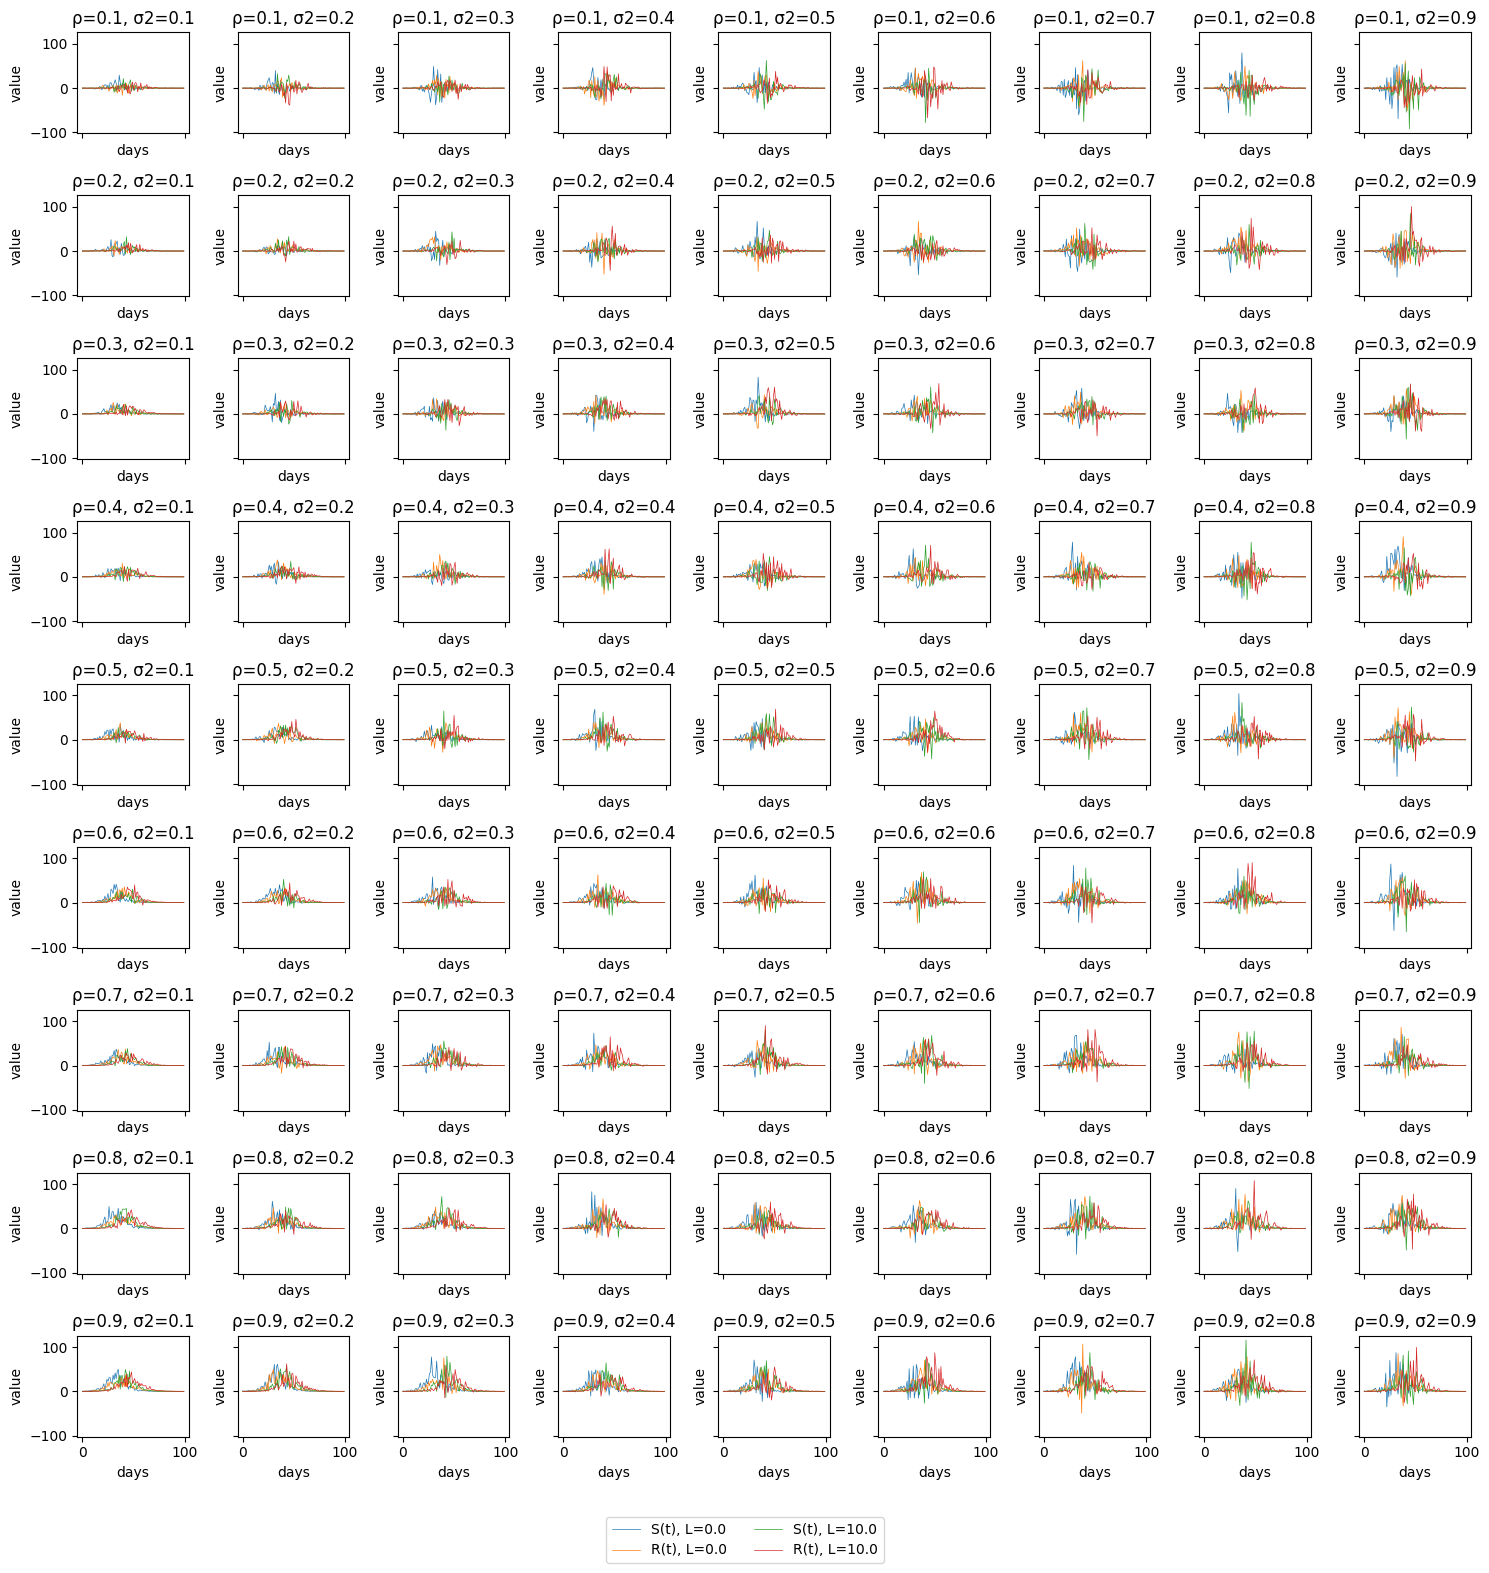

In [185]:
explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list)

The picked ranges are
* rho = [0.1, 0.9]
* sigma = [0.3, 0.9]
* L = [1, 10]
  
the most diverse dynamics are observed.

In [186]:
def generate_noisy_sir_data(num_samples, lam, mu, I0, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        rho = np.random.uniform(0.1, 0.9)
        sigma2 = np.random.uniform(0.3, 0.9)
        L = np.random.randint(1,10)

        X, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0, rho, sigma2, L])

    return np.array(data), np.array(target)



Training mode ...
Epoch 1/50, Loss: 1.0714
Epoch 6/50, Loss: 0.1712
Epoch 11/50, Loss: 0.0759
Epoch 16/50, Loss: 0.0445
Epoch 21/50, Loss: 0.0331
Epoch 26/50, Loss: 0.0231
Epoch 31/50, Loss: 0.0195
Epoch 36/50, Loss: 0.0210
Epoch 41/50, Loss: 0.0176
Epoch 46/50, Loss: 0.0169


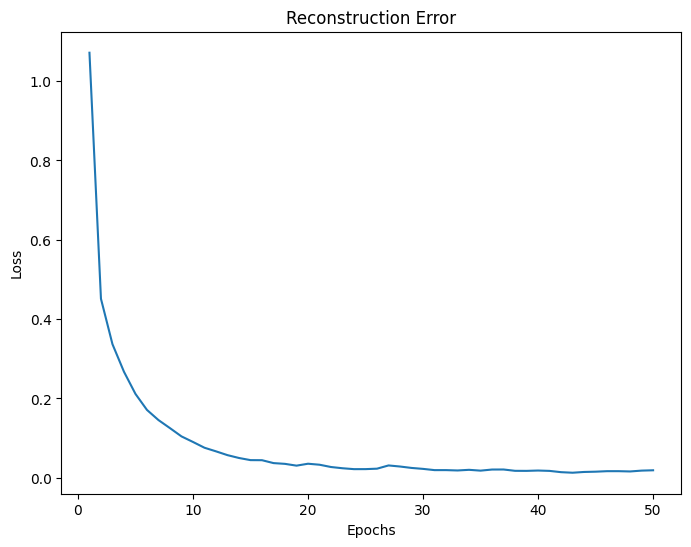

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


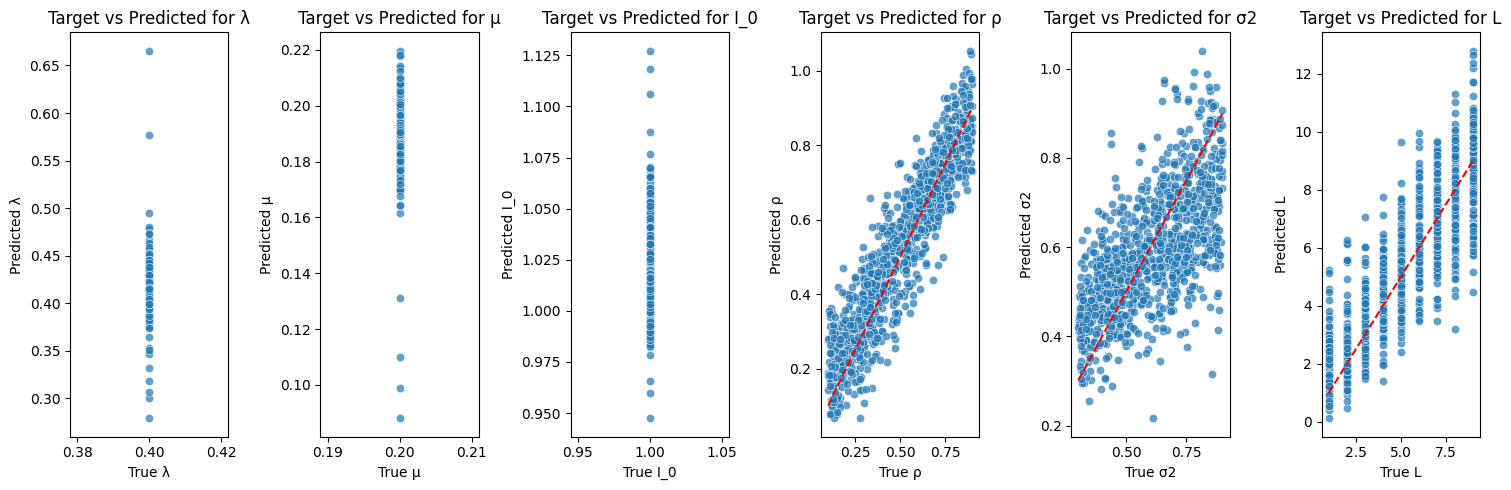

In [187]:
# hyperparameters
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 6 # [lam, mu, I0, rho, sigma2, L]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_noisy_sir_data(num_samples, lam, mu, I0, T, N)
x_test, y_test = generate_noisy_sir_data(num_samples=test_samples, lam=lam, mu=mu, I0=I0, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


Conditional RealNVP

Training mode ...
Epoch 1/100, Loss: 0.0140
Epoch 3/100, Loss: -2.1475
Epoch 5/100, Loss: -2.5254
Epoch 7/100, Loss: -2.7530
Epoch 9/100, Loss: -2.8578
Epoch 11/100, Loss: -2.9653
Epoch 13/100, Loss: -3.1074
Epoch 15/100, Loss: -3.2094
Epoch 17/100, Loss: -3.2270
Epoch 19/100, Loss: -3.4091
Epoch 21/100, Loss: -3.5005
Epoch 23/100, Loss: -3.4579
Epoch 25/100, Loss: -3.6250
Epoch 27/100, Loss: -3.6739
Epoch 29/100, Loss: -3.7662
Epoch 31/100, Loss: -3.8803
Epoch 33/100, Loss: -3.7017
Epoch 35/100, Loss: -3.8497
Epoch 37/100, Loss: -3.9504
Epoch 39/100, Loss: -4.0527
Epoch 41/100, Loss: -4.0664
Epoch 43/100, Loss: -4.0664
Epoch 45/100, Loss: -4.1173
Epoch 47/100, Loss: -4.1152
Epoch 49/100, Loss: -4.2125
Epoch 51/100, Loss: -4.3131
Epoch 53/100, Loss: -4.2117
Epoch 55/100, Loss: -4.1901
Epoch 57/100, Loss: -4.0880
Epoch 59/100, Loss: -4.3522
Epoch 61/100, Loss: -4.0129
Epoch 63/100, Loss: -4.2642
Epoch 65/100, Loss: -4.1146
Epoch 67/100, Loss: -4.4761
Epoch 69/100, Loss: -4.4762
Epoch 71

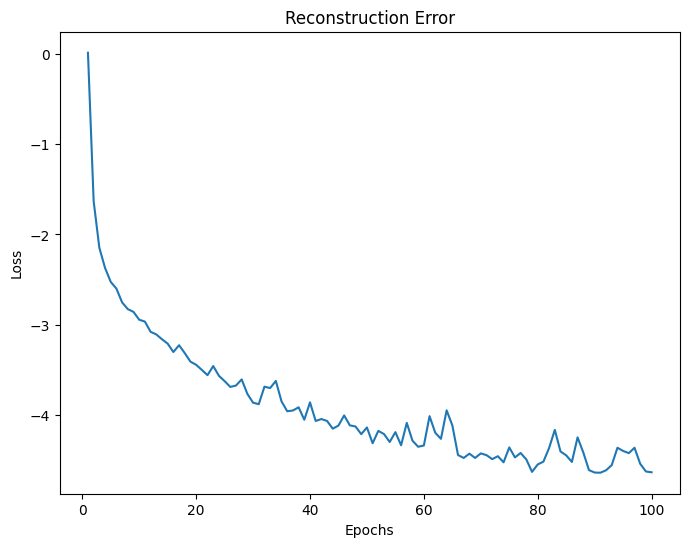

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_19825/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


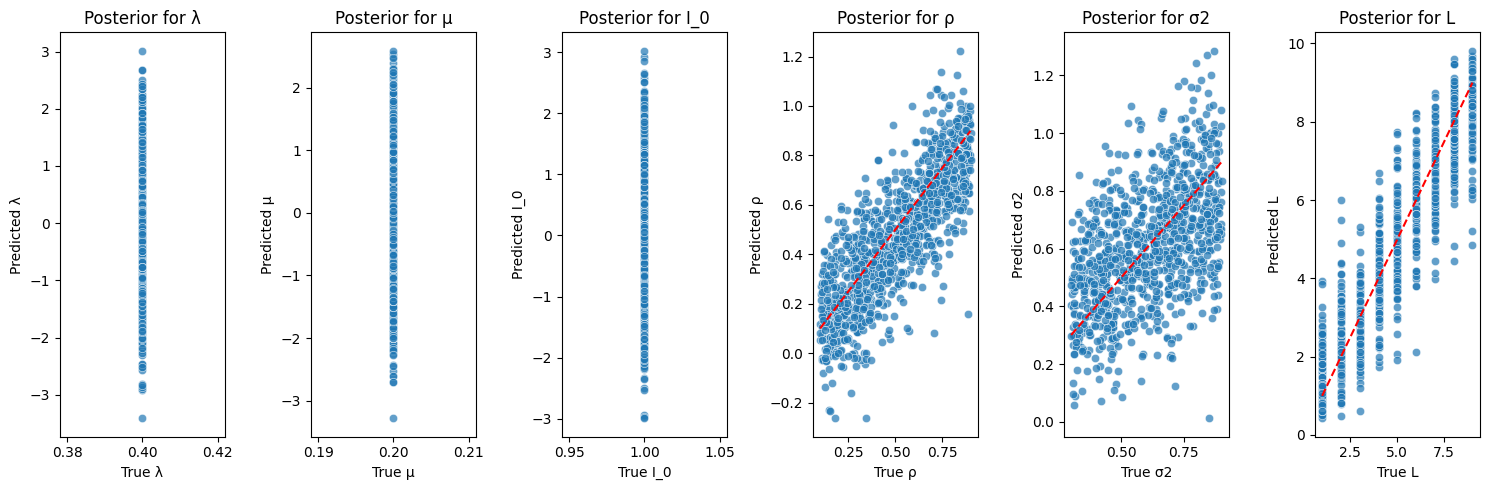

In [188]:
# Hyperparameters
input_size = T*2 # Flattened (dS, dR)
hidden_size = 128
batch_size = 64
lr = 0.001
epochs = 100
n_layers=2

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=6, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


posterior distributions

Mean Energy Score: -2.6365
Standard Deviation of Energy Scores: 1.9096


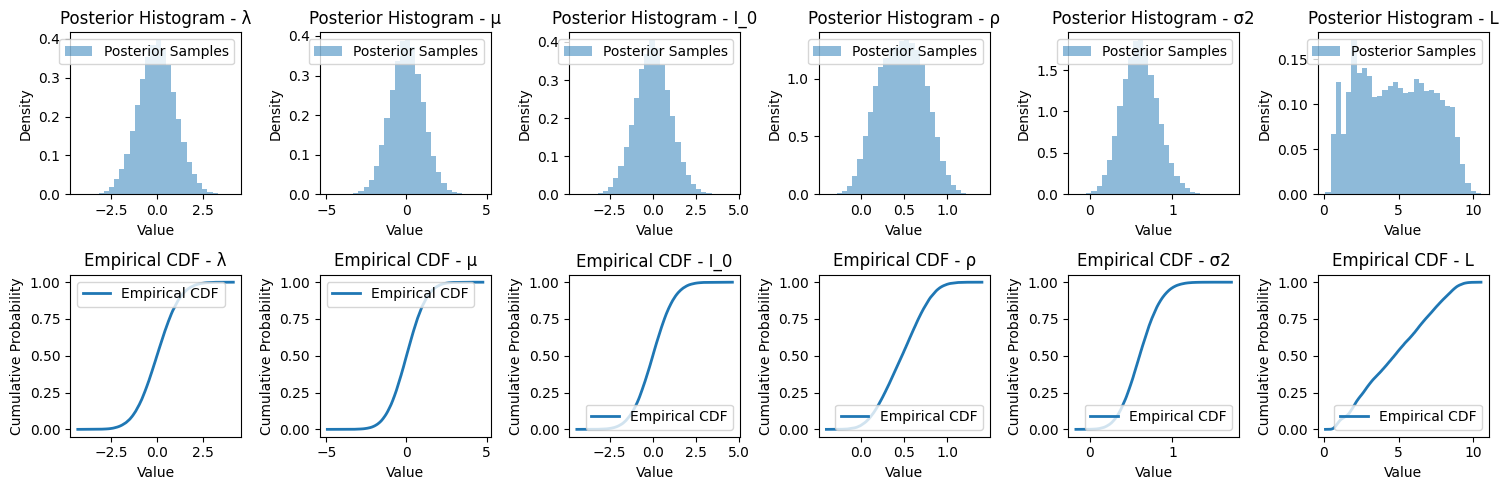

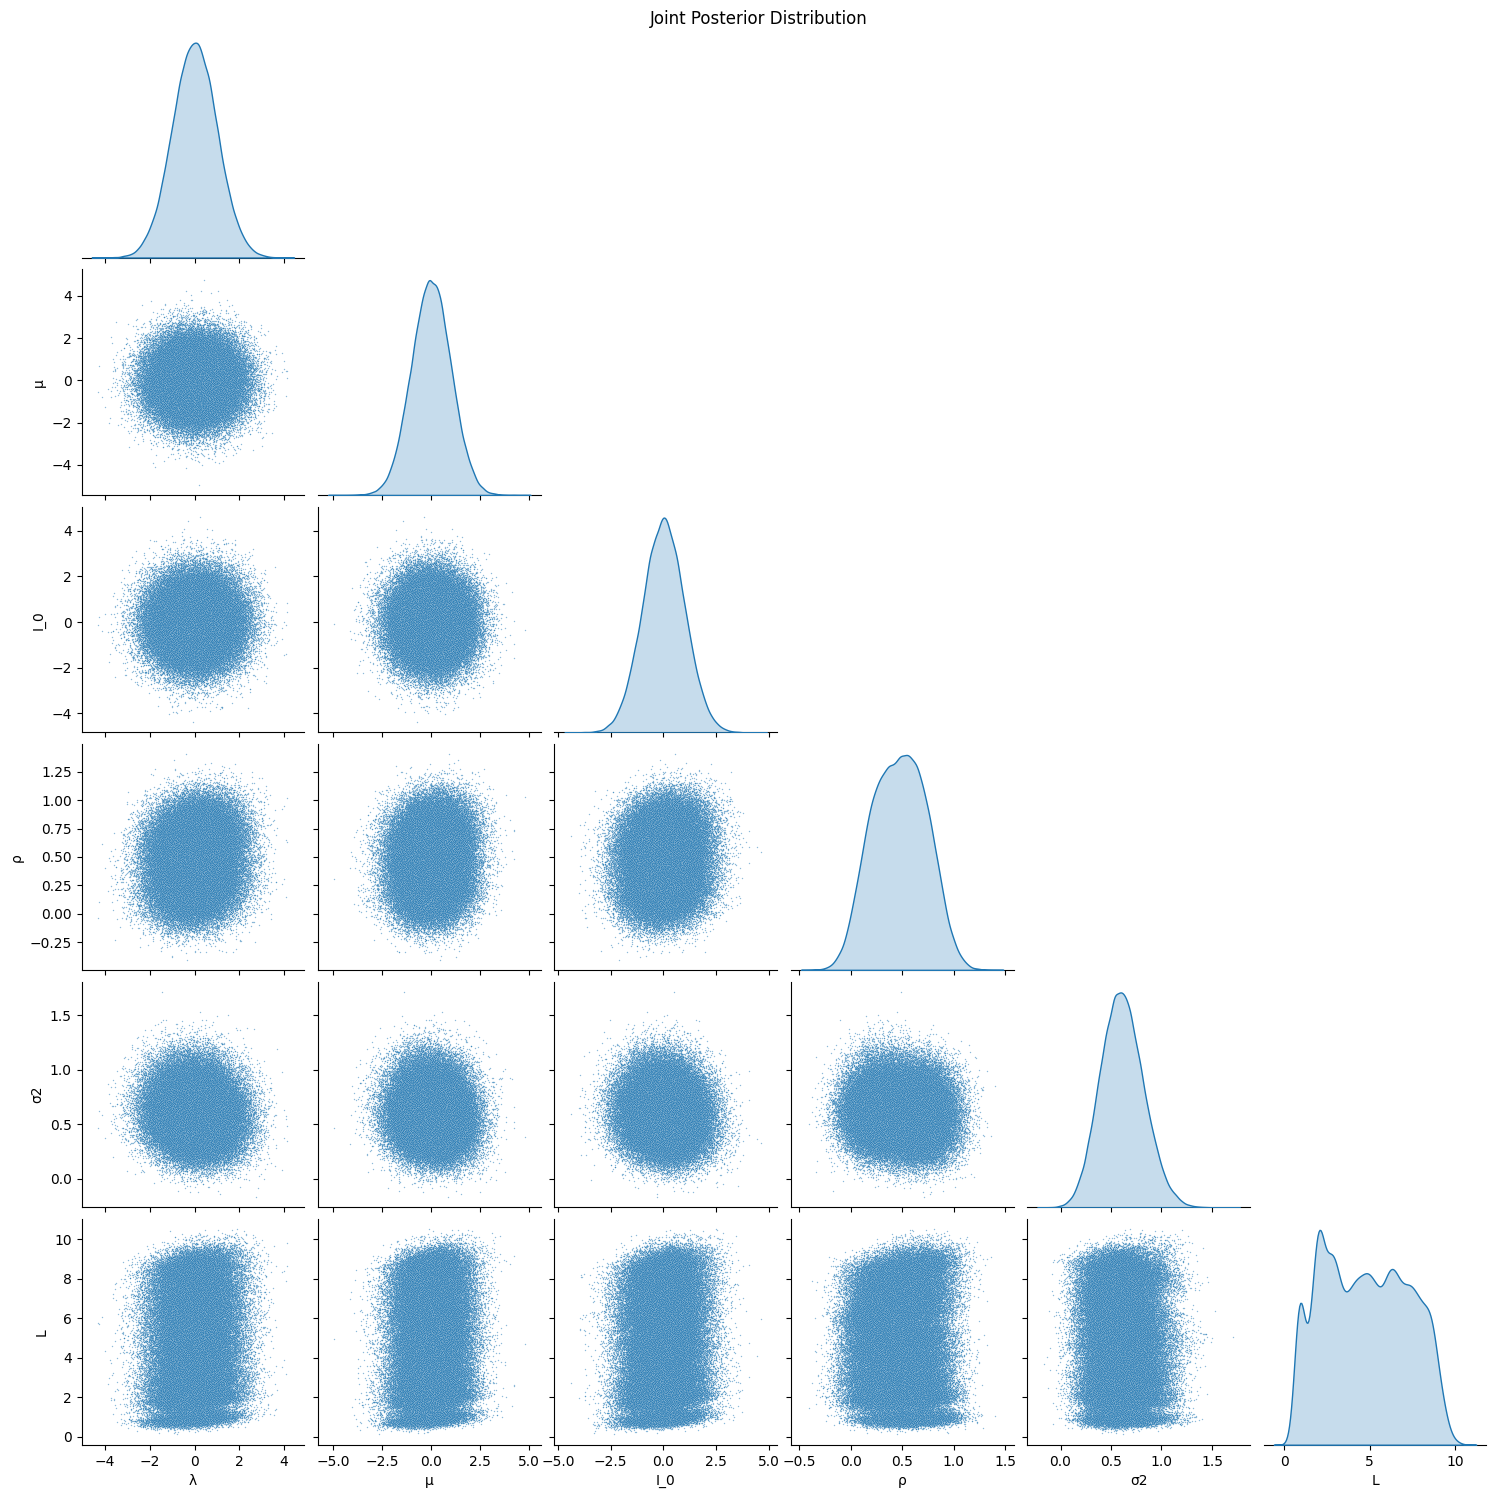

In [189]:
num_preds = 100
input_size = 6
params = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)

#### TASK 3

In [190]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(dataloader))
    return loss_history

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

##### Simluate Data

Simple data shape: (100, 2)
Noisy data shape: (100, 2)


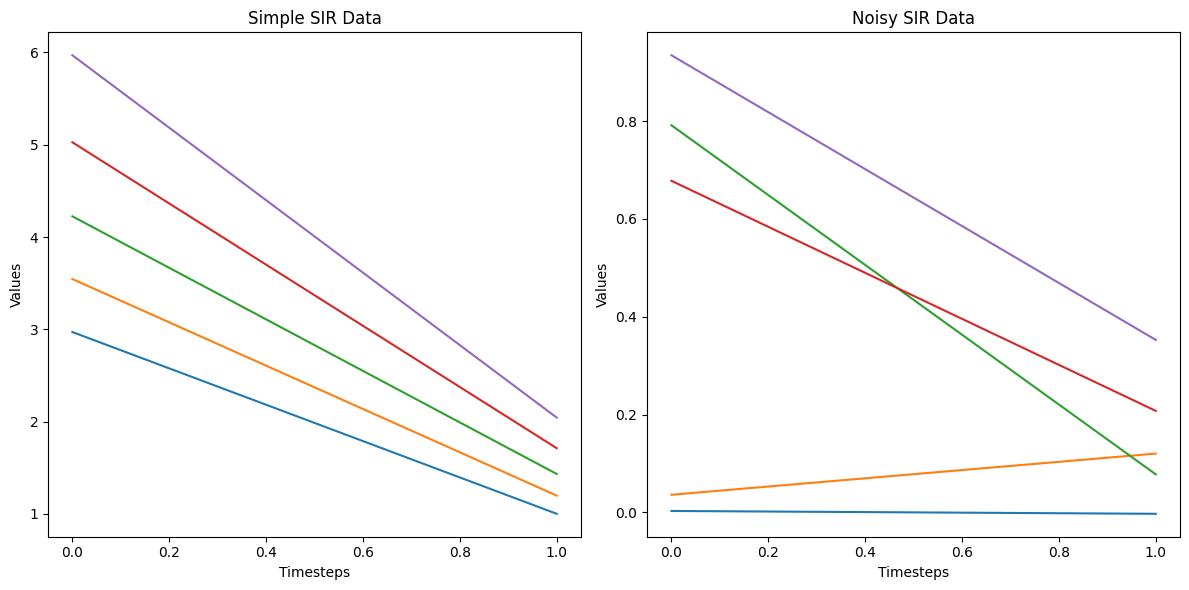

In [191]:
# Generate test data using simulate_sir_simple()
lam = 0.3
mu = 0.1
I0 = 10
T = 100
N = 1000
simple_data, simple_states = simulate_sir_simple(lam, mu, I0, T, N)


# Generate test data using simulate_sir_noisy()
noise_level = 0.1
sigma2 = noise_level**2
L = 1
noisy_data, noisy_states = simulate_sir_noisy(lam, mu, I0, L, noise_level, sigma2, T, N)


# Display the shapes of the generated data
print("Simple data shape:", simple_data.shape)
print("Noisy data shape:", noisy_data.shape)

# Plot a few samples of the generated data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot simple data
plt.subplot(1, 2, 1)
plt.plot(simple_data[:5].T)
plt.title("Simple SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

# Plot noisy data
plt.subplot(1, 2, 2)
plt.plot(noisy_data[:5].T)
plt.title("Noisy SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

plt.tight_layout()
plt.show()

#### Train Networks with NLL and MMD Loss
Modify the training process to include both NLL and MMD loss on the output of the summary network h(X).

Epoch 1/50, Loss: 13.030197858810425
Epoch 2/50, Loss: 5.460317254066467
Epoch 3/50, Loss: 3.2141206860542297
Epoch 4/50, Loss: 3.043914020061493
Epoch 5/50, Loss: 2.5992525219917297
Epoch 6/50, Loss: 2.384310483932495
Epoch 7/50, Loss: 2.0925441682338715
Epoch 8/50, Loss: 2.091485559940338
Epoch 9/50, Loss: 1.802594929933548
Epoch 10/50, Loss: 1.6822779774665833
Epoch 11/50, Loss: 1.6675647795200348
Epoch 12/50, Loss: 1.7502136826515198
Epoch 13/50, Loss: 1.6425112783908844
Epoch 14/50, Loss: 1.7075842916965485
Epoch 15/50, Loss: 1.706441342830658
Epoch 16/50, Loss: 1.572163462638855
Epoch 17/50, Loss: 1.709019660949707
Epoch 18/50, Loss: 1.70994833111763
Epoch 19/50, Loss: 1.7704327702522278
Epoch 20/50, Loss: 1.7132887542247772
Epoch 21/50, Loss: 1.7942045032978058
Epoch 22/50, Loss: 1.8851246237754822
Epoch 23/50, Loss: 1.6348056495189667
Epoch 24/50, Loss: 1.8116359114646912
Epoch 25/50, Loss: 1.6099899113178253
Epoch 26/50, Loss: 1.6782192289829254
Epoch 27/50, Loss: 1.5918467938

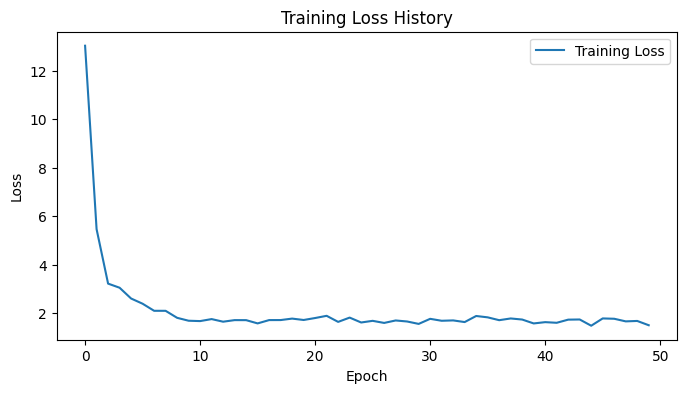

In [192]:
# Define the MMD loss function
def mmd_loss(output, target):
    """
    Compute the Maximum Mean Discrepancy (MMD) loss.
    
    Parameters:
    output (torch.Tensor): Output of the summary network.
    target (torch.Tensor): Target distribution (standard normal).
    
    Returns:
    torch.Tensor: MMD loss.
    """
    # Compute the MMD loss between the output and the target
    xx, yy, zz = torch.mm(output, output.t()), torch.mm(target, target.t()), torch.mm(output, target.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    K = torch.exp(-0.5 * (rx.t() + rx - 2*xx))
    L = torch.exp(-0.5 * (ry.t() + ry - 2*yy))
    P = torch.exp(-0.5 * (rx.t() + ry - 2*zz))
    beta = (1./(output.size(0)*output.size(0)))
    gamma = (2./(output.size(0)*target.size(0)))
    return beta * (K.sum() + L.sum()) - gamma * P.sum()

# Define the neural network model
class SummaryNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SummaryNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare the data
input_dim = simple_data.shape[1]
hidden_dim = 128
output_dim = 10
num_samples = simple_data.shape[0]

# Convert data to PyTorch tensors
simple_data_tensor = torch.tensor(simple_data, dtype=torch.float32)
noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)

# Create DataLoader for simple data
simple_dataset = TensorDataset(simple_data_tensor, torch.zeros(num_samples, output_dim))
simple_dataloader = DataLoader(simple_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss functions, and optimizer
model = SummaryNetwork(input_dim, hidden_dim, output_dim)
nll_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with NLL and MMD loss
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in simple_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Generate standard normal target
        target = torch.randn_like(outputs)
        
        # Compute NLL and MMD loss
        loss_nll = nll_loss(outputs, target)
        loss_mmd = mmd_loss(outputs, target)
        loss = loss_nll + loss_mmd
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    loss_history.append(epoch_loss / len(simple_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(simple_dataloader)}")

# Plot the training loss history
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

#### Evaluate Null Hypothesis with Noise-Free Data
Use test data generated by simulate_sir_simple() to ensure that the null hypothesis cannot be rejected for noise-free data at common p-values.

In [193]:
# Generate outputs from the trained model
model.eval()
with torch.no_grad():
    outputs = model(simple_data_tensor)

# Perform Chi-Square test
chi2_stat, p_value = stats.chisquare(outputs.numpy().flatten())

# Print the Chi-Square test results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

# Check if the null hypothesis can be rejected at 1% significance level
alpha = 0.01
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data follows the standard normal distribution.")

Chi-Square Statistic: -27549.028906595227
P-Value: 1.0
Fail to reject the null hypothesis: The data follows the standard normal distribution.


#### Evaluate Model with Noisy Data
Use test data created with simulate_sir_noisy() to determine the conditions under which the model mismatch is detected by the χ2 test.

In [194]:

# Prepare the noisy data
noisy_dataset = TensorDataset(noisy_data_tensor, torch.zeros(num_samples, output_dim))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)

# Generate outputs from the trained model using noisy data
model.eval()
with torch.no_grad():
    noisy_outputs = model(noisy_data_tensor)

# Perform Chi-Square test on noisy data
chi2_stat_noisy, p_value_noisy = stats.chisquare(noisy_outputs.numpy().flatten())

# Print the Chi-Square test results for noisy data
print(f"Chi-Square Statistic (Noisy Data): {chi2_stat_noisy}")
print(f"P-Value (Noisy Data): {p_value_noisy}")

# Check if the null hypothesis can be rejected at 1% significance level for noisy data
if p_value_noisy < alpha:
    print("Reject the null hypothesis: The noisy data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The noisy data follows the standard normal distribution.")

# Test with increasing noise levels and increasing test set size
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Chi-Square Statistic (Noisy Data): 1973.8846817054882
P-Value (Noisy Data): 1.9821665636500667e-66
Reject the null hypothesis: The noisy data does not follow the standard normal distribution.
Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 1942.7547320181313, P-Value: 4.1925588172866765e-63
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 3344.1336094052085, P-Value: 3.455221245035414e-71
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 8097.696698002383, P-Value: 6.7094790684789315e-152
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 15642.7921349094, P-Value: 1.4350259190384736e-256
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 3605.3223241198316, P-Value: 1.947873826732018e-290
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 4242.6411034875, P-Value: 3.2338972790359577e-163
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 8398.34036398259, P-Value: 1.1874869520884364e-177
Noise Level: 0.2, Test Set S

#### Results
Test with increasing noise levels and test set sizes, and comment on the findings.

In [195]:
# Test with increasing noise levels and increasing test set sizes
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 2546.5059310559045, P-Value: 1.0241229749321174e-135
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 4058.3412507567396, P-Value: 1.945219114068326e-142
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 7646.045609987722, P-Value: 4.683693970641293e-116
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 15766.537019493342, P-Value: 2.4270934998661105e-266
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 2836.177189042596, P-Value: 2.5447831146654174e-175
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 6783.101772142332, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 8194.073715742814, P-Value: 5.354892814993432e-160
Noise Level: 0.2, Test Set Size: 1000, Chi-Square Statistic: 15296.641024848279, P-Value: 5.806605861313109e-230
Noise Level: 0.3, Test Set Size: 100, Chi-Square Statistic: 9950.34110692291, P-Value: 0.0
Noise Level: 0.3, Test Set Size

- we have demonstrated how to use the MMD loss to detect model mismatch in the context of a simple SIR model. 

- We have shown that the MMD loss can be used in conjunction with the NLL loss to improve the detection of model mismatch in noisy data. 

- By comparing the results of the χ2 test on the output of the summary network h(X) with the MMD loss, we have shown that the MMD loss can be used to detect model mismatch in noisy data.

#### TASK 4 - Sensitivity analysis

In [207]:
# 4 Sensitivity analysis
# Vary the variance of the prior distribution psim (Y ) (individually for each parameter) during trai-
# ning and make your networks hyperparameter aware. That is, pass the current settings of the
# (log-)variance as an additional input/condition to the networks, so that they learn the correct p os-
# terior p(Y |h(X),Var(Y )) for each setting of the variance vector Var(Y ). In this way, the networks
# amortize the variability in Var(Y ), and sensitivity tests b ecome suciently cheap to b e practical
# (otherwise, you would have to train a new mo del for each setting of Var(Y ), which would b e pro-
# hibitively exp ensive). Use a test set to determine how the p osterior changes under variations of
# Var(Y ) and comment on your ndings. Are there parameters which are more sensitive to the choice
# of prior than others? (This would mean that the data are not as informative ab out these parameters
# as we would like them to b e.)
